# Experimentação de modelos

## Modelos
- Prophet
- sktime
- timeGPT
- PMDArima
- Ensemble Methods: XGBoost, LightGBM, RandomForest
- MAs
- LSTMs

## Métricas
- MAPE

## Dependências


In [56]:
import pandas as pd
import numpy as np
from prophet import Prophet
from sktime.split import temporal_train_test_split
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.arima import AutoARIMA
from sktime.forecasting.arima import ARIMA
from sktime.utils.plotting import plot_series
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')

## Variáveis globais

In [57]:
PATH = '../data/historico_acoes_b3.csv'
TICKER = 'BBAS3.SA'

## Leitura dos dados

In [58]:
df = pd.read_csv(PATH)
df = df[df.Ticker == TICKER][['Date', 'Adj Close']]
df.index = pd.to_datetime(df.Date)
df = df.drop(columns=['Date'])

df = df.asfreq('B')  # 'B' para dias úteis
df['Adj Close'] = df['Adj Close'].fillna(method='ffill')  # Preenche valores ausentes com o último valor conhecido

display(df.head())

,Adj Close
Date,
2000-01-03 00:00:00+00:00,0.504046
2000-01-04 00:00:00+00:00,0.480073
2000-01-05 00:00:00+00:00,0.484991
2000-01-06 00:00:00+00:00,0.491752
2000-01-07 00:00:00+00:00,0.480688


(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='Adj Close'>)

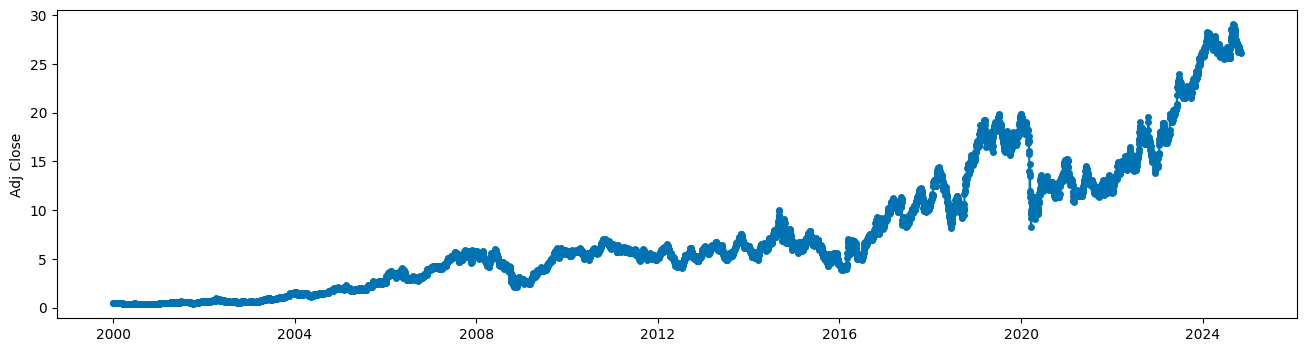

In [23]:
plot_series(df)

## ARIMA

In [40]:
y_train, y_test = temporal_train_test_split(df['Adj Close'], test_size=0.2)

In [41]:
class SKTimeForecaster:
    """ Classe com métodos de forecasting que podem ser utilizados para qualquer modelo do sktime """
    
    def __init__(self):
        pass
    
    def evaluate_forecast(self, y, y_pred):
        mae = mean_absolute_error(y, y_pred)
        mse = mean_squared_error(y, y_pred)
        mape = mean_absolute_percentage_error(y, y_pred)
        return {'mae': mae, 'mse': mse, 'mape': mape}

    def train_model(self, y_train, model, evaluate=False, horizon=365, y_test=None):
        fh = ForecastingHorizon(np.arange(1, horizon + 1), is_relative=True)

        model.fit(y_train)
        y_pred = model.predict(fh)
        
        if evaluate:
            print(self.evaluate_forecast(y_test, y_pred))
        
        return y_pred

### Treinamento e validação do modelo

{'mae': 8.098565987699518, 'mse': 96.25446772642408, 'mape': 0.3395734637699587}


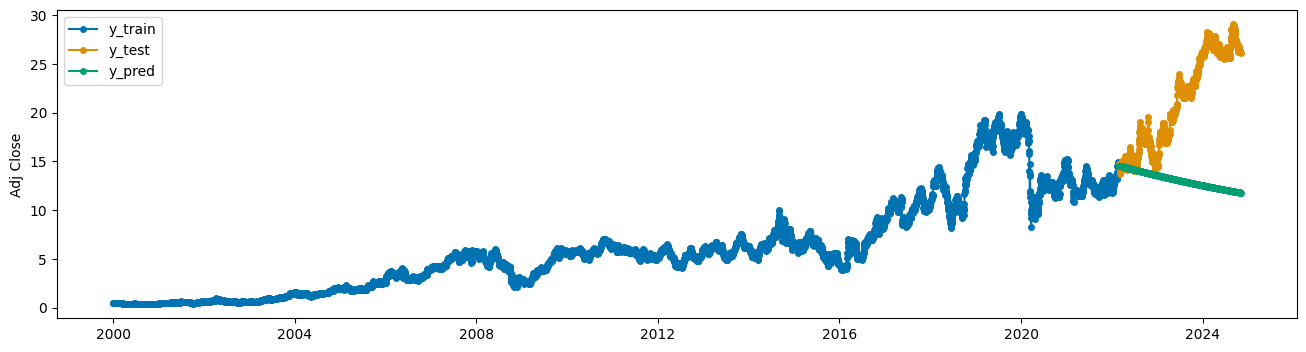

In [43]:
model = ARIMA()

y_test_pred = SKTimeForecaster().train_model(y_train, model, evaluate=True, y_test=y_test, horizon=len(y_test))

plot_series(y_train, y_test, y_test_pred, labels=['y_train', 'y_test', 'y_pred'])
plt.show()

### Treinamento com dados completos

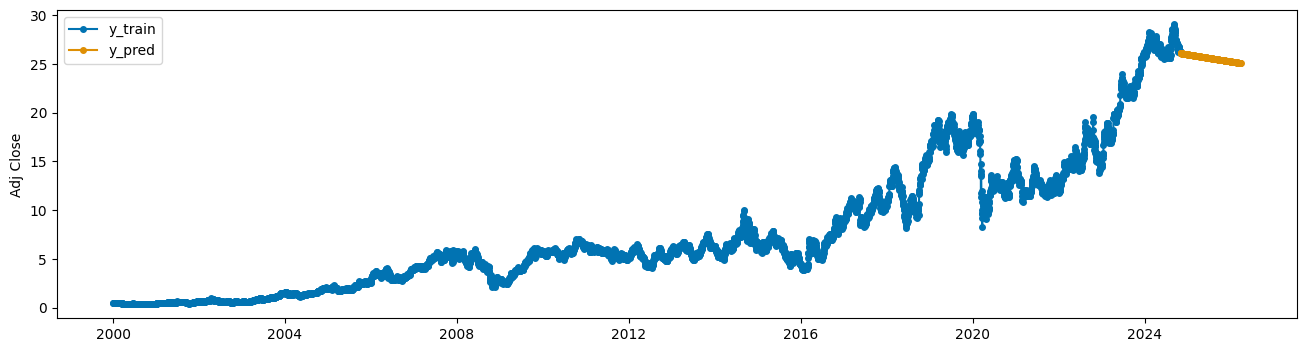

In [44]:
model = ARIMA()

y_pred = SKTimeForecaster().train_model(df['Adj Close'], model, horizon=365)

plot_series(df['Adj Close'], y_pred, labels=['y_train', 'y_pred'])
plt.show()

### Auto-ARIMA

{'mae': 6.061944905462073, 'mse': 55.87351795821888, 'mape': 0.2517737909995907}


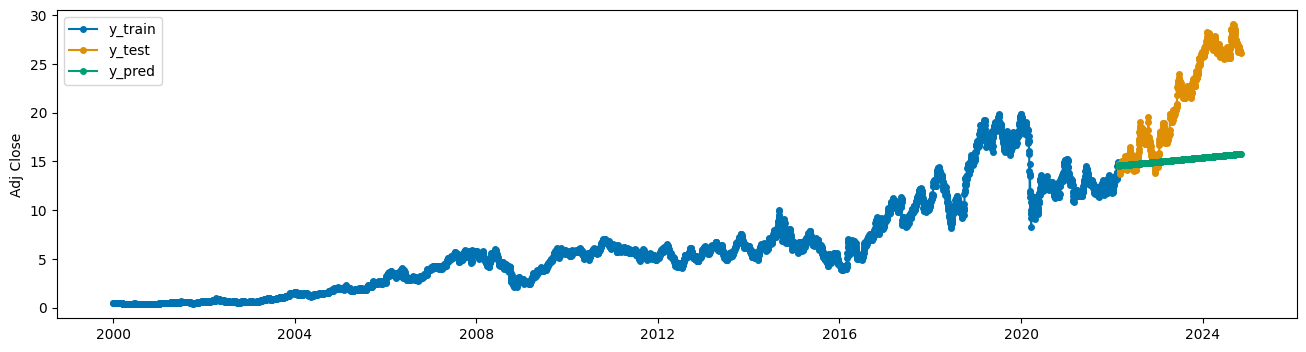

In [52]:
model = AutoARIMA(n_fits=50)

y_test_pred = SKTimeForecaster().train_model(y_train, model, evaluate=True, y_test=y_test, horizon=len(y_test))

plot_series(y_train, y_test, y_test_pred, labels=['y_train', 'y_test', 'y_pred'])
plt.show()

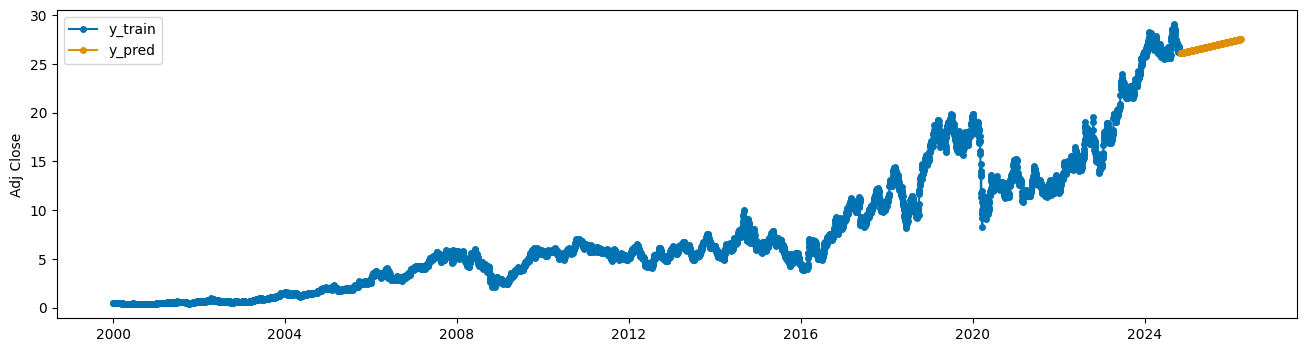

In [46]:
model = AutoARIMA()
 
y_pred = SKTimeForecaster().train_model(df['Adj Close'], model, horizon=365)

plot_series(df['Adj Close'], y_pred, labels=['y_train', 'y_pred'])
plt.show()

In [19]:
df

,ds,y
0,2007-12-10,9.590761
1,2007-12-11,8.519590
2,2007-12-12,8.183677
3,2007-12-13,8.072467
4,2007-12-14,7.893572
...,...,...
2900,2016-01-16,7.817223
2901,2016-01-17,9.273878
2902,2016-01-18,10.333775
2903,2016-01-19,9.125871


In [49]:
from sktime.datasets import load_airline
from sktime.forecasting.ets import AutoETS
from sktime.utils.plotting import plot_series

In [53]:
from sktime.forecasting.arima import AutoARIMA
from sktime.forecasting.model_evaluation import evaluate
from sktime.split import ExpandingWindowSplitter

In [61]:
forecaster = AutoARIMA(sp=12, suppress_warnings=True)

cv = ExpandingWindowSplitter(
    step_length=12, fh=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], initial_window=72
)

evaluation = evaluate(forecaster=forecaster, y=df['Adj Close'], cv=cv, strategy="refit", return_data=True)

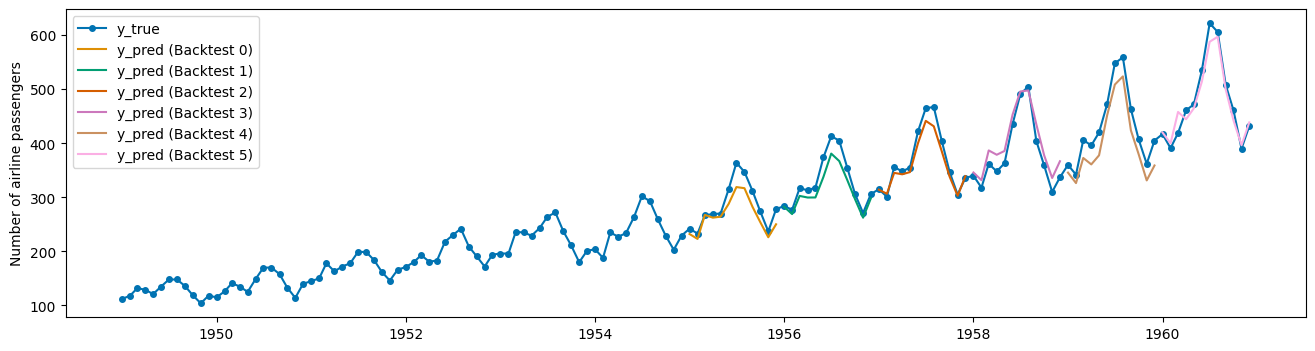

In [55]:
# visualization of a forecaster evaluation
fig, ax = plot_series(
    df['Adj Close'],
    evaluation["y_pred"].iloc[0],
    evaluation["y_pred"].iloc[1],
    evaluation["y_pred"].iloc[2],
    evaluation["y_pred"].iloc[3],
    evaluation["y_pred"].iloc[4],
    evaluation["y_pred"].iloc[5],
    markers=["o", "", "", "", "", "", ""],
    labels=["y_true"] + ["y_pred (Backtest " + str(x) + ")" for x in range(6)],
)
ax.legend();

## Supervised Learning Algorithms

In [ ]:
from sklearn.neighbors import KNeighborsRegressor

from sktime.forecasting.compose import make_reduction

In [ ]:
regressor = KNeighborsRegressor(n_neighbors=1)
forecaster = make_reduction(regressor, window_length=15, strategy="recursive")

In [ ]:
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
mean_absolute_percentage_error(y_test, y_pred, symmetric=False)

In [ ]:
from sklearn.neighbors import KNeighborsRegressor

from sktime.forecasting.compose import make_reduction
from sktime.forecasting.model_selection import ForecastingGridSearchCV
from sktime.split import SlidingWindowSplitter

In [ ]:
regressor = KNeighborsRegressor()
forecaster = make_reduction(regressor, window_length=15, strategy="recursive")
param_grid = {"window_length": [7, 12, 15]}

# We fit the forecaster on an initial window which is 80% of the historical data
# then use temporal sliding window cross-validation to find the optimal hyper-parameters
cv = SlidingWindowSplitter(initial_window=int(len(y_train) * 0.8), window_length=20)
gscv = ForecastingGridSearchCV(
    forecaster, strategy="refit", cv=cv, param_grid=param_grid
)

In [ ]:
gscv.fit(y_train)
y_pred = gscv.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
mean_absolute_percentage_error(y_test, y_pred, symmetric=False)